## PHYS-253

## Homework 4

Handed out: Saturday, May 3, 2025

**Due: 4.59 pm; Monday, May 19, 2025**

## Instructions

a) You are allowed to discuss with your fellow students HOW to solve the problems. Collaboration is encouraged! But you need to hand in your INDIVIDUAL SOLUTION.  

d) List AI assistants (e.g., ChatGPT) that you worked with in arriving at a solution, or other software/tool; see detailed instructions in next cell.

c) You can use code from previous lectures/labs - you don't neeed to reference this, it is part of the knowledge you acquired in this course.  However, if you use code from other sources, you MUST include a reference to the source.

d) Submit your Notebook (with solutions/answers) to Phys-253 site (area: ΕΡΓΑΣΙΕΣ / HW4).

### On the use of AI assistants (e.g., ChatGPT, or other Generative A.I. tools)

ChatGPT can be used as an on-line “office hours” resource to help with your learning.
You can use ChatGPT-generated code (e.g. as inspiration if you are stuck or other reasons), however, submission of ChatGPT-generated
code without explanation or acknowledgment will earn you 0 credit. See cell below.

__________________________________________________________________________________________________________________________

## Problem 1

Train a variational autoencoder (VAE) on an dataset (*other than MNIST and Fashion MNIST*) of your choice, and use it to generate new (synthetic) data.

Hint 1: Example Notebooks will be uploaded in Week 10 or Week 11 areas; they will be discussed in class, on Monday, May 5.

Hint 2: You may use ChatGPT or other AI tools (but state what your prompt question was).

100%|██████████| 170M/170M [01:06<00:00, 2.58MB/s]


Epoch 1, Loss: 1901.2354
Epoch 2, Loss: 1838.7535
Epoch 3, Loss: 1830.9817
Epoch 4, Loss: 1828.2461
Epoch 5, Loss: 1826.3547
Epoch 6, Loss: 1824.9434
Epoch 7, Loss: 1823.6420
Epoch 8, Loss: 1822.8355
Epoch 9, Loss: 1822.0162
Epoch 10, Loss: 1821.4199
Epoch 11, Loss: 1821.0450
Epoch 12, Loss: 1820.5163
Epoch 13, Loss: 1820.1881
Epoch 14, Loss: 1819.9500
Epoch 15, Loss: 1819.6269
Epoch 16, Loss: 1819.3682
Epoch 17, Loss: 1819.1513
Epoch 18, Loss: 1818.9147
Epoch 19, Loss: 1818.7899
Epoch 20, Loss: 1818.6005


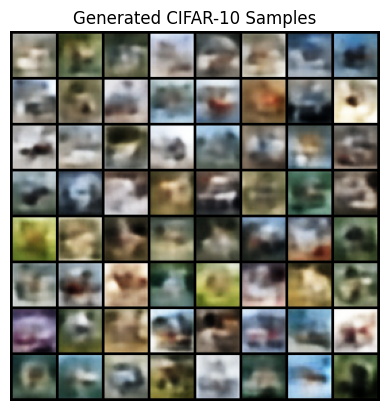

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 128
batch_size = 128
epochs = 20
lr = 1e-3

transform = transforms.Compose([
    transforms.ToTensor(),
])
train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 8x8
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 64 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # 32x32
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x_enc = self.encoder(x)
        mu = self.fc_mu(x_enc)
        logvar = self.fc_logvar(x_enc)
        z = self.reparameterize(mu, logvar)
        x_dec = self.fc_decode(z)
        x_rec = self.decoder(x_dec)
        return x_rec, mu, logvar

def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        recon_x, mu, logvar = model(x)
        loss = loss_fn(recon_x, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    samples = model.decoder(model.fc_decode(z)).cpu()
    vutils.save_image(samples, 'vae_cifar10_samples.png', nrow=8)
    plt.imshow(np.transpose(vutils.make_grid(samples, nrow=8, padding=2, normalize=True), (1, 2, 0)))
    plt.title("Generated CIFAR-10 Samples")
    plt.axis('off')
    plt.show()



## Problem 2

In this problem you will make certain changes to an image dataset (in this problem, the dataset can be MNIST or Fashion MNIST) and use it to train a VAE and to generate new images. You will generate images of your choice and you will compare the quality of the images with those in the training dataset.

a) Add Gaussian noise to the training dataset, train a VAE, generate images and compare their quality to the quality of the training set (which has been contaminated by noise). Try different levels of noise.

b) Instead of adding Gaussian noise to the training dataset, add dropout, train a VAE and generate images. How do they compare to the quality of the images generated in part a)? Try different levels of dropout.

c) Add Gaussian noise *and* dropout to the training dataset. Train a VAE generate images and compare their quality to the images generated in parts a) and b). Try different combinations of noise and dropout levels.

Hint: this peoblem will be discussed in class (Monday, May 5)

100%|██████████| 26.4M/26.4M [00:01<00:00, 21.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 334kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.11MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.8MB/s]


=== (a) Clean data ===
Epoch  1 | Loss: 285.0286
Epoch  2 | Loss: 255.7462
Epoch  3 | Loss: 250.2696
Epoch  4 | Loss: 247.5971
Epoch  5 | Loss: 245.9549
Epoch  6 | Loss: 244.9004
Epoch  7 | Loss: 244.1753
Epoch  8 | Loss: 243.6018
Epoch  9 | Loss: 243.0590
Epoch 10 | Loss: 242.6807



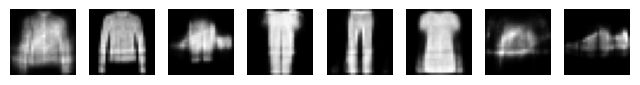

=== (b) Gaussian Noise ===
Epoch  1 | Loss: 419.4691
Epoch  2 | Loss: 405.0805
Epoch  3 | Loss: 402.5719
Epoch  4 | Loss: 401.4309
Epoch  5 | Loss: 400.6954
Epoch  6 | Loss: 400.0897
Epoch  7 | Loss: 399.6742
Epoch  8 | Loss: 399.3430
Epoch  9 | Loss: 399.0550
Epoch 10 | Loss: 398.8316



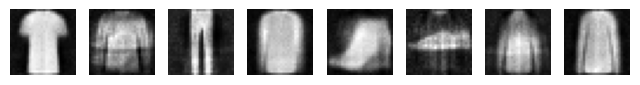

=== (c) Dropout ===
Epoch  1 | Loss: 296.2419
Epoch  2 | Loss: 273.6251
Epoch  3 | Loss: 269.1272
Epoch  4 | Loss: 266.8816
Epoch  5 | Loss: 265.5800
Epoch  6 | Loss: 264.7299
Epoch  7 | Loss: 264.1563
Epoch  8 | Loss: 263.7471
Epoch  9 | Loss: 263.4361
Epoch 10 | Loss: 263.1956



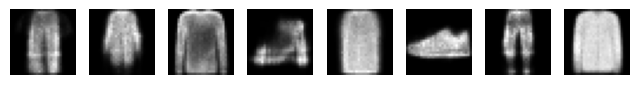

=== (d) Noise + Dropout ===
Epoch  1 | Loss: 392.6256
Epoch  2 | Loss: 380.4850
Epoch  3 | Loss: 377.8898
Epoch  4 | Loss: 376.6946
Epoch  5 | Loss: 376.1031
Epoch  6 | Loss: 375.8446
Epoch  7 | Loss: 375.4470
Epoch  8 | Loss: 375.2571
Epoch  9 | Loss: 375.0006
Epoch 10 | Loss: 374.8192



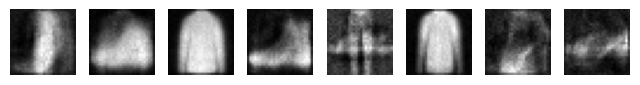

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noisy = tensor + torch.randn_like(tensor) * self.std + self.mean
        return torch.clamp(noisy, 0., 1.)

class DropoutDataset(Dataset):
    def __init__(self, base_dataset, p=0.3):
        self.dataset = base_dataset
        self.p = p

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        mask = torch.bernoulli((1 - self.p) * torch.ones_like(img))
        return img * mask, label

clean_transform = transforms.ToTensor()
clean_ds = datasets.FashionMNIST(root='./data', train=True, download=True,
                                 transform=clean_transform)

noise_transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.3),
])
ds_noise = datasets.FashionMNIST(root='./data', train=True, download=True,
                                 transform=noise_transform)

ds_dropout = DropoutDataset(clean_ds, p=0.3)

ds_both = DropoutDataset(
    datasets.FashionMNIST(root='./data', train=True, download=True,
                          transform=noise_transform),
    p=0.3
)

batch_size = 128
loader_clean   = DataLoader(clean_ds,     batch_size=batch_size, shuffle=True)
loader_noise   = DataLoader(ds_noise,     batch_size=batch_size, shuffle=True)
loader_drop    = DataLoader(ds_dropout,   batch_size=batch_size, shuffle=True)
loader_both    = DataLoader(ds_both,      batch_size=batch_size, shuffle=True)



class VAE(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc_mu     = nn.Linear(400, 20)
        self.fc_logvar = nn.Linear(400, 20)
        self.decoder   = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# 3) Loss + Training

def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train_vae(model, dataloader, epochs=10):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0
        for imgs, _ in dataloader:
            imgs = imgs.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(imgs)
            loss = loss_fn(recon, imgs, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg = total_loss / len(dataloader.dataset)
        print(f"Epoch {ep:2d} | Loss: {avg:.4f}")
    print()

def generate_images(model, n=8):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, 20).to(device)
        samples = model.decode(z).cpu().numpy()
    fig, axes = plt.subplots(1, n, figsize=(n,1))
    for i in range(n):
        axes[i].imshow(samples[i][0], cmap='gray')
        axes[i].axis('off')
    plt.show()



print("=== (a) Clean data ===")
vae_clean = VAE(dropout=0.0)
train_vae(vae_clean, loader_clean, epochs=10)
generate_images(vae_clean)

print("=== (b) Gaussian Noise ===")
vae_noise = VAE(dropout=0.0)
train_vae(vae_noise, loader_noise, epochs=10)
generate_images(vae_noise)

print("=== (c) Dropout ===")
vae_drop = VAE(dropout=0.3)
train_vae(vae_drop, loader_drop, epochs=10)
generate_images(vae_drop)

print("=== (d) Noise + Dropout ===")
vae_both = VAE(dropout=0.3)
train_vae(vae_both, loader_both, epochs=10)
generate_images(vae_both)


## Problem 3: Morphing a fashion MNIST image
    
Train a VAE on the Fashion MNIST dataset and morph a sweater to a shoe.

Present your morphing work as an animation.

Epoch 1/10 — avg loss: 285.2034
Epoch 2/10 — avg loss: 256.5944
Epoch 3/10 — avg loss: 250.9786
Epoch 4/10 — avg loss: 248.0274
Epoch 5/10 — avg loss: 246.3330
Epoch 6/10 — avg loss: 245.1597
Epoch 7/10 — avg loss: 244.3629
Epoch 8/10 — avg loss: 243.7384
Epoch 9/10 — avg loss: 243.1385
Epoch 10/10 — avg loss: 242.7764


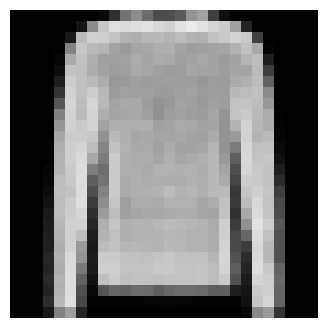

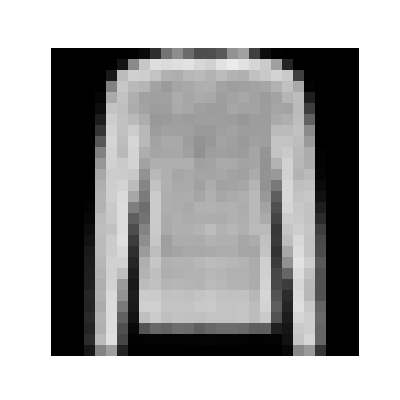

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 20
batch_size = 128
epochs = 10
lr = 1e-3
steps = 20  # number of interpolation frames

transform = transforms.ToTensor()
train_ds = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

def get_example(ds, target_class):
    for img, lbl in ds:
        if lbl == target_class:
            return img.unsqueeze(0).to(device)
    raise ValueError(f"class {target_class} not found")

sweater_img = get_example(train_ds, 2)  # Pullover
shoe_img    = get_example(train_ds, 9)  # Ankle boot

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_fc1 = nn.Linear(28*28, 400)
        self.enc_mu  = nn.Linear(400, latent_dim)
        self.enc_lv  = nn.Linear(400, latent_dim)
        self.dec_fc1 = nn.Linear(latent_dim, 400)
        self.dec_fc2 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = F.relu(self.enc_fc1(x.view(-1, 784)))
        return self.enc_mu(h), self.enc_lv(h)

    def reparam(self, mu, logvar):
        std = (0.5 * logvar).exp()
        return mu + std * torch.randn_like(std)

    def decode(self, z):
        h = F.relu(self.dec_fc1(z))
        return torch.sigmoid(self.dec_fc2(h)).view(-1,1,28,28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar

def loss_fn(recon, x, mu, logvar):
    bce = F.binary_cross_entropy(recon, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld

model = VAE().to(device)
opt   = optim.Adam(model.parameters(), lr=lr)

for ep in range(1, epochs+1):
    model.train()
    total = 0
    for xb, _ in train_loader:
        xb = xb.to(device)
        recon, mu, lv = model(xb)
        loss = loss_fn(recon, xb, mu, lv)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()
    print(f"Epoch {ep}/{epochs} — avg loss: {total/len(train_ds):.4f}")

model.eval()
with torch.no_grad():
    mu_sweater, _ = model.encode(sweater_img)
    mu_shoe,    _ = model.encode(shoe_img)

alphas = torch.linspace(0, 1, steps)
latents = [(1 - a)*mu_sweater + a*mu_shoe for a in alphas]

with torch.no_grad():
    frames = [ model.decode(z).cpu().squeeze(0).squeeze(0).numpy() for z in latents ]

fig = plt.figure(figsize=(4,4))
plt.axis('off')
im = plt.imshow(frames[0], cmap='gray', vmin=0, vmax=1)

def update(i):
    im.set_data(frames[i])
    return (im,)

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=200, blit=True)

plt.show()

ani.save('sweater_to_shoe.gif', writer='pillow', fps=5)

from IPython.display import Image, display
display(Image(filename='sweater_to_shoe.gif'))


## Problem 4

This problem highligths the importance of KL divergence as a loss function. It is of particular importance to a conceptual understanding of Variational AutoEncoders (VAEs), which transform the discrete codings distribution (in latent space) of an AutoEncoder (AE) to the continuous distribution (in latent space, usually a multivariate normal distribution) from which new data (e.g. new images) can be sampled from. In VAEs, the KL divergence loss function is added to the reconstruction loss to produce new images resembling the original ones.

#### Your task:

1. Define s "target" normalized Gaussian distribution (denoted by blue color) and an "initial" normalized Gaussian distribution (red color) of your choice.

2. Write code (or consult ChatGPT on providing code) to plot distributions (starting from the "initial" distribution) that continually minimize the KL divergence from the "target" distribution.  

3. Plot all distributions in a single plot.

HINT: the following schematics can serve as a guide.

![image.png](attachment:image.png)

![image.png](attachment:image.png)

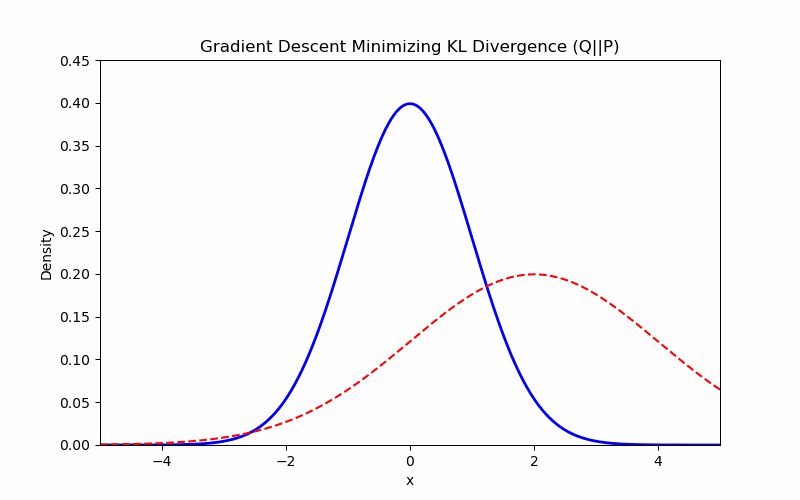

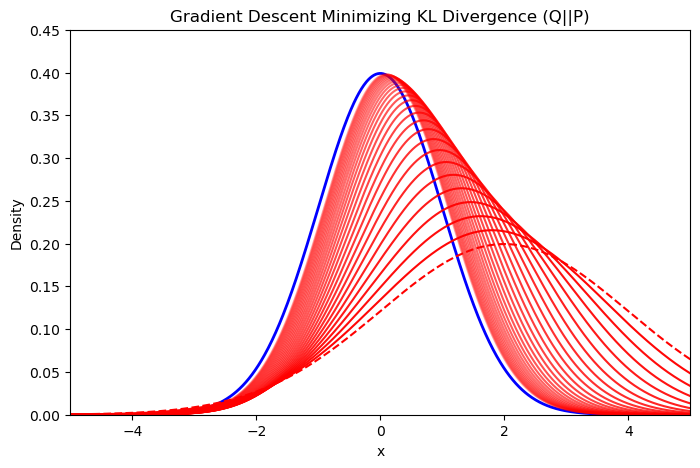

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.animation import FuncAnimation, PillowWriter

def grad_kl(mu_q, std_q, mu_p=0, std_p=1):
    dmu = (mu_q - mu_p) / std_p**2
    dstd = (std_q - std_p**2 / std_q) / std_p**2
    return dmu, dstd

mu_init, std_init = 2.0, 2.0
mu_target, std_target = 0.0, 1.0

lr = 0.1
steps = 30
x = np.linspace(-5, 5, 1000)

mus, stds, pdfs = [], [], []
mu_q, std_q = mu_init, std_init
for _ in range(steps):
    mus.append(mu_q)
    stds.append(std_q)
    pdfs.append(norm.pdf(x, mu_q, std_q))
    dmu, dstd = grad_kl(mu_q, std_q, mu_target, std_target)
    mu_q -= lr * dmu
    std_q -= lr * dstd

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_xlim([-5, 5])
ax.set_ylim([0, 0.45])
ax.set_xlabel("x")
ax.set_ylabel("Density")
ax.set_title("Gradient Descent Minimizing KL Divergence (Q||P)")

ax.plot(x, norm.pdf(x, mu_target, std_target), color='blue', linewidth=2, label='Target N(0,1)')

lines = []

def update(frame):
    for line in lines:
        line.remove()
    lines.clear()
    for i in range(frame + 1):
        alpha = 0.3 + 0.7 * (1 - i / (steps - 1))
        linestyle = '--' if i == 0 else '-'
        line, = ax.plot(x, pdfs[i], color='red', alpha=alpha, linestyle=linestyle)
        lines.append(line)
    return lines

# Create animation
ani = FuncAnimation(fig, update, frames=len(pdfs), interval=200, blit=True, repeat_delay=1000)

ani.save('kl_divergence_full_steps.gif', writer=PillowWriter(fps=5))

from IPython.display import Image, display
display(Image(filename='kl_divergence_full_steps.gif'))


***You will get EXTRA BONUS if you present your KL work as an animation.***

##### Done



## Problem 5

KL divergence is a useful metric of "probability distribution distance", widely used in deep learning. However, it is not considered as a "true" distance metric. Why? Write up short text to compare KL divergence with Wsserstein distance. You may consult Wikipedia, ChatGPT, or other sources (do not forget to mention your sources).

### Γιατί η KL Απόκλιση δεν είναι αληθινή μετρική

Η KL (Kullback–Leibler) απόκλιση μεταξύ δύο κατανομών πιθανότητας \(P\) και \(Q\) ορίζεται ως:

> **Διακριτή περίπτωση**  
> $$
D_{\mathrm{KL}}(P\parallel Q)
= \sum_{x} P(x)\,\log\left(\frac{P(x)}{Q(x)}\right)
$$

> **Συνεχής περίπτωση**  
> $$
D_{\mathrm{KL}}(P\parallel Q)
= \int P(x)\,\ln\left(\frac{P(x)}{Q(x)}\right)\,dx
$$

Ωστόσο, η KL απόκλιση δεν πληροί τα κριτήρια μιας μετρικής απόστασης:

- Δεν είναι συμμετρική:
$$  D_{\mathrm{KL}}(P\parallel Q) \ne D_{\mathrm{KL}}(Q\parallel P) $$
- Δεν ικανοποιεί την ανισότητα τριγώνου:  
  Υπάρχουν κατανομές \(A, B, C\) για τις οποίες ισχύει:
 $$ D_{\mathrm{KL}}(A\parallel C) > D_{\mathrm{KL}}(A\parallel B) + D_{\mathrm{KL}}(B\parallel C)
$$
- Μπορεί να είναι άπειρη:  
  Αν για κάποιο x, $$(P(x) > 0)$$ και $$(Q(x) = 0),$$ τότε $$ 
  D_{\mathrm{KL}}(P\parallel Q) = \infty$$

Συνεπώς, η KL είναι μέτρο απόκλισης, όχι πραγματική απόσταση.

---

### Η Wasserstein Απόσταση

Η Wasserstein απόσταση είναι πραγματική μετρική μεταξύ κατανομών και ορίζεται ως:

$$
W(P, Q)
= \inf_{\gamma \in \Gamma(P, Q)}
  \int_{\mathcal{X} \times \mathcal{X}} d(x, y) \, d\gamma(x, y)
$$

Όπου (Gamma(P, Q)) είναι το σύνολο όλων των συνεζεύξεων με περιθώρια \(P\) και \(Q\).

Βασικές ιδιότητες:

- Είναι συμμετρική:  
$$
  W(P,Q) = W(Q,P)
  $$
- Ικανοποιεί την ανισότητα τριγώνου:  
 $$
  W(P,R) \le W(P,Q) + W(Q,R)
  $$
- Είναι πάντα πεπερασμένη (αν οι κατανομές έχουν πεπερασμένη πρώτη ροπή)

- Δεν απαιτεί επικάλυψη στηριγμάτων (λειτουργεί ακόμα και όταν οι κατανομές δεν έχουν κοινό στήριγμα)

- Συλλαμβάνει τη "γεωμετρική" διαφορά μεταξύ των κατανομών

---

### Σύνοψη 

- Η KL απόκλιση:
  - ✗ Δεν είναι συμμετρική
  - ✗ Δεν ικανοποιεί την ανισότητα τριγώνου
  - ✗ Μπορεί να είναι άπειρη
  - ✗ Δεν λειτουργεί όταν τα στηρίγματα δεν επικαλύπτονται
  - ✓ Χρησιμοποιείται κυρίως σε VAEs και παραμετρική συμπερασματολογία

- Η Wasserstein απόσταση:
  - ✓ Είναι συμμετρική
  - ✓ Ικανοποιεί την ανισότητα τριγώνου
  - ✓ Είναι πάντα πεπερασμένη (αν οι 1ες ροπές υπάρχουν)
  - ✓ Λειτουργεί χωρίς απαραίτητη επικάλυψη
  - ✓ Χρησιμοποιείται σε WGANs και μεταφορές βέλτιστης μάζας (optimal transport)


### References

1. [Wasserstein metric — Wikipedia](https://en.wikipedia.org/wiki/Wasserstein_metric)  
2. [Kullback–Leibler divergence — Wikipedia](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)
3. https://g.co/gemini/share/9d23c3e2a897
4. https://chatgpt.com/share/6838e90d-c1e8-8013-b51b-ce6168e98f80


__________________________________________________________________________________________________________________________